<a href="https://colab.research.google.com/github/jwt625/PlayGround/blob/main/neurips25/resources/measuring_energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on Session: Benchmarking the Energy Consumption of Image Generation

---

**Make sure you switch the notebook runtime to GPU!**

The tutorial will work with the default GPU runtime with NVIDIA T4.

---

We'll be using Hugging Face Diffusers to run a small SD Turbo diffusion model for text-to-image.

In [1]:
import time
import logging
logging.basicConfig(level=logging.INFO, format="[%(asctime)s] [%(name)s:%(lineno)d] %(message)s")
logging.getLogger("zeus").setLevel(logging.INFO)

import torch
import matplotlib.pyplot as plt
from diffusers import AutoPipelineForText2Image

pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sd-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/1.73G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


## Installing Zeus

- GitHub: https://github.com/ml-energy/zeus
- Documentation: https://ml.energy/zeus

In [2]:
%%capture
!pip install zeus

## Setting Up Measurement

Zeus provides a few convenient classes for measurement.

### `ZeusMonitor`

The main `ZeusMonitor` class lets you measure the energy consumption of arbitrary *ranges* or *windows* of code. You let the monitor know the range of code by beginning and ending a **measurement window** under a consistent name.

```python
monitor.begin_window("much compute")
# Much
# Compute
measurement = monitor.end_window("much compute")
```

These windows can be **nested** arbitrarily, and With `str`-based window names, you can just pass around the `ZeusMonitor` object everywhere and measure any range of execution as needed.

### `PowerMonitor`

This is another convenience class that measures the power draw of the GPU over time in the background. Just instantiating the class will automatically start power monitoring, and you can later query power draw over any range of time.

```python
# GPU index -> List of (timestamp, power)
timeline: dict[int, list[tuple[float, float]]] = power_monitor.get_power_timeline("device_instant")
```

In [3]:
from zeus.monitor import ZeusMonitor, PowerMonitor

# Collects device power consumption in the background
power_monitor = PowerMonitor()

# Measures time and energy within "windows" of execution
monitor = ZeusMonitor()

INFO:zeus.device.gpu.nvidia:pynvml is available and initialized.
INFO:zeus.monitor.power:Monitoring power usage of GPUs [0]
INFO:zeus.monitor.power:Detected Tesla T4, inferring GPU power counter update period.
INFO:zeus.monitor.power:Counter update period for Tesla T4 is 0.09 s
INFO:zeus.monitor.power:Power domain device_instant is supported
INFO:zeus.monitor.power:Power domain device_average is not supported
INFO:zeus.monitor.power:Power domain memory_average is not supported
INFO:zeus.monitor.power:Supported power domains: ['device_instant']
INFO:zeus.monitor.power:Waiting for all power monitoring subprocesses to be ready...
INFO:zeus.monitor.power:All power monitoring subprocesses are ready
INFO:zeus.device.cpu.rapl:RAPL is not supported on this CPU.
INFO:zeus.monitor.energy:Monitoring GPU indices [0].
INFO:zeus.monitor.energy:Monitoring CPU indices []


## Exercise: Measuring Energy Consumption

Our goal is to measure the **energy consumption of generating one image**.

An important parameter that affects this is inference *batch size*: the number of images generated at the same time. So we want to normalize/average correctly.

INFO:zeus.monitor.energy:ZeusMonitor reset with no active windows to drop.
INFO:zeus.utils.framework:PyTorch with CUDA support is available.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

batch size: 1, generation time: 0.5920098781585693 s, energy per generation: 37.13 J


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

batch size: 2, generation time: 0.9399852752685547 s, energy per generation: 21.82 J


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

batch size: 4, generation time: 1.7443854331970214 s, energy per generation: 16.99 J


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

batch size: 8, generation time: 3.379043388366699 s, energy per generation: 15.39 J
The whole benchmark consumed an aggregate of 2708.467999999999 Joules.

Looks good! 🎉



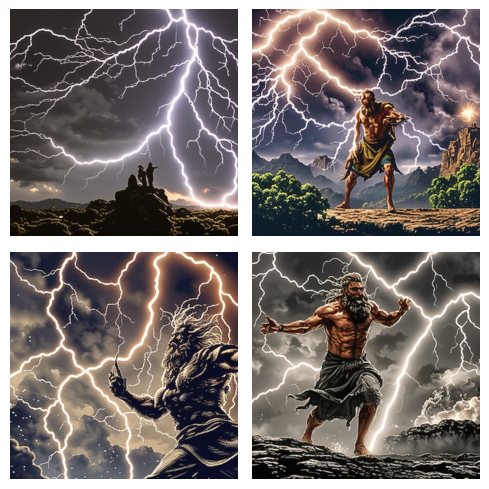

In [4]:
prompt = "A cinematic scene of Zeus throwing lightning"
num_repeats = 5
batch_sizes = [1, 2, 4, 8]
images = []
latency_measurements = []
energy_measurements = []
start_time = time.time()
monitor.reset_windows()

monitor.begin_window("whole benchmark")

# Warm up
for _ in range(5):
    _ = pipe(prompt=[prompt] * 4, num_inference_steps=1, guidance_scale=0.0)

# Measurement
for batch_size in [1, 2, 4, 8]:

    monitor.begin_window("image generation")

    # Run `num_repeats` repetitions for stable measurement
    for _ in range(num_repeats):
        output = pipe(prompt=[prompt] * batch_size, num_inference_steps=4, guidance_scale=0.0)
        images.extend(output.images)

    ###################### FIXME #######################
    # The monitor has to know from where to where we're
    # trying to measure the energy of.
    measurement = monitor.end_window("image generation")
    ####################################################

    latency = measurement.time / num_repeats

    ################################ FIXME ###############################
    # We want to know how much energy was consumed per generated image.
    energy_per_image = measurement.total_energy  / len(images)
    ######################################################################

    latency_measurements.append(latency)
    energy_measurements.append(energy_per_image)
    print(f"batch size: {batch_size}, generation time: {latency} s, energy per generation: {energy_per_image:.2f} J")

measurement = monitor.end_window("whole benchmark")
print(f"The whole benchmark consumed an aggregate of {measurement.total_energy} Joules.")
power_timeline = power_monitor.get_all_power_timelines(start_time=start_time - 5.0)

# Draw images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), tight_layout=True)
axes = axes.flatten()
for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis("off")

# Validation
if energy_measurements[0] < energy_measurements[-1]:
    print("\nOops, wanna double check the second FIXME?\nThe monitor measures the energy consumption of `batch_size` many image generations.\n")
    raise AssertionError
elif not all(energy < 100.0 for energy in energy_measurements):
    print("\nOops, wanna double check the second FIXME?\nWe measured running the same image generation batch `num_repeats` times.\n")
    raise AssertionError
else:
    print("\nLooks good! 🎉\n")

## Understanding the Measurements

Let's look at how our measurements look like. First run the cell below.

### Plot 1: Changing Batch Size

How does changing the batch size impact time and energy?

**Interpretations:**
- With a larger batch size, latency increases because the amount of computation increases.
- Energy consumption **per image** decreases because the GPU’s fixed costs (e.g., idle/static power, scheduling overhead) are amortized better over more parallel image generations.

### Plot 2: Power Over Time

We can visualize the `PowerMonitor`’s power draw timeline to better understand how GPU power usage behaves during image generation. Power readings tend to fluctuate significantly over time, especially for instantaneous measurements. Overall, the power draw pattern reflects how actively the GPU is being utilized during computation.  

**Interpretations:**  
- During image generation, the power draw stays close to **70 W**, which matches the **Thermal Design Power (TDP)** of the NVIDIA T4 GPU provided by Colab.
- Even with a batch size of 1, the GPU is already quite well utilized (though not fully saturated) because T4 is a small GPU, and thus exhibits quite high power draw.  
- Instant power draw can **exceeds 70 W** for short bursts. This is normal, since **TDP does not mean a hard cap** but a specification indicating that *the windowed average power draw* will not exceed 70 W.

Text(0, 0.5, 'Device instant power (W)')

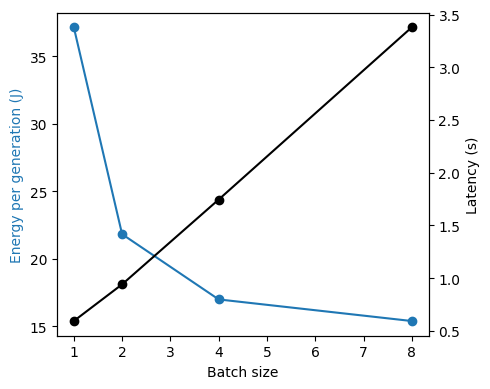

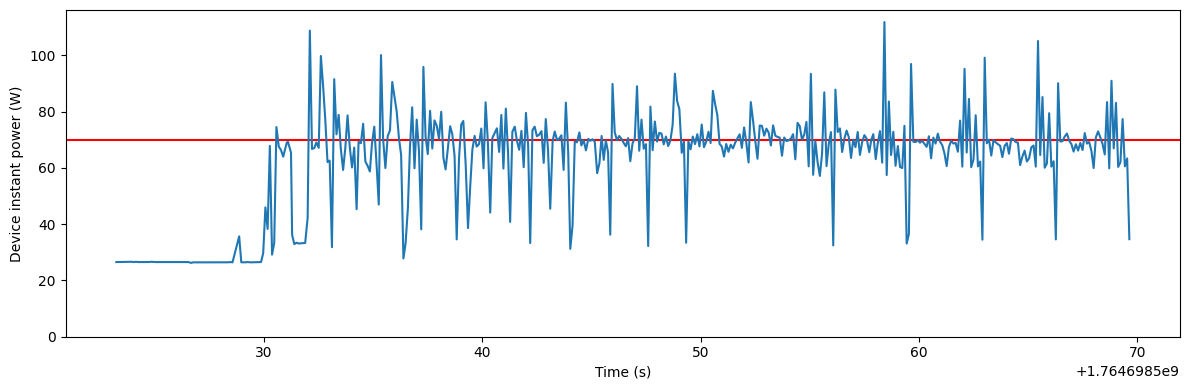

In [5]:
# Plotting
fig, ax1 = plt.subplots(figsize=(5, 4), tight_layout=True)
ax2 = ax1.twinx()
ax1.plot(batch_sizes, energy_measurements, marker="o")
ax2.plot(batch_sizes, latency_measurements, marker="o", color="black")
ax1.set_xlabel("Batch size")
ax1.set_ylabel("Energy per generation (J)", color="C0")
ax2.set_ylabel("Latency (s)")

fig, ax = plt.subplots(figsize=(12, 4), tight_layout=True)
ax.axhline(70, color="red")
timeline = power_timeline["device_instant"][0]
ax.plot([entry[0] for entry in timeline], [entry[1] for entry in timeline])
ax.set_ylim(0)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Device instant power (W)")